In [2]:
# ===== Packages: Baiscs =====

import pandas as pd
import numpy as np

import joblib
import statsmodels.api as sm

from matplotlib import pyplot as plt

plt.style.use('classic')
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{ebgaramond}",
    }
)


In [3]:
# 读取数据
df_mdl = pd.read_csv('OnlineRetail_clean.csv')

df_mdl


,Date,StockCode,Country,Description,Quantity,revenue,UnitPrice,month,DoM,DoW,stock_age_days,sku_avg_p,LnP,LnQ,dLnP,dLnQ
0,2010-12-01,10002,France,INFLATABLE POLITICAL GLOBE,48,40.80,0.85,12,1,2,0,0.850000,-0.162519,3.871201,-0.173158,1.046094
1,2010-12-01,10002,United Kingdom,INFLATABLE POLITICAL GLOBE,12,10.20,0.85,12,1,2,0,0.850000,-0.162519,2.484907,-0.173158,-0.340200
2,2010-12-01,10125,United Kingdom,MINI FUNKY DESIGN TAPES,2,1.70,0.85,12,1,2,0,0.850000,-0.162519,0.693147,-0.015594,-2.211211
3,2010-12-01,10133,United Kingdom,COLOURING PENCILS BROWN TUBE,5,4.25,0.85,12,1,2,0,0.659667,-0.162519,1.609438,0.257981,-1.615385
4,2010-12-01,10135,United Kingdom,COLOURING PENCILS BROWN TUBE,1,2.51,2.51,12,1,2,0,1.250000,0.920283,0.000000,0.551839,-2.918686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294521,2011-12-09,90202C,United Kingdom,GREEN ENAMEL FLOWER HAIR TIE,1,2.90,2.90,12,9,4,367,2.950000,1.064711,0.000000,-0.010554,-0.430783
294522,2011-12-09,90202D,United Kingdom,PINK ENAMEL FLOWER HAIR TIE,1,2.90,2.90,12,9,4,357,2.900000,1.064711,0.000000,-0.005003,-0.693147
294523,2011-12-09,90206C,United Kingdom,CRYSTAL DIAMANTE STAR BROOCH,1,4.98,4.98,12,9,4,373,4.980000,1.605430,0.000000,-0.002490,-0.461346
294524,2011-12-09,90208,United Kingdom,PAIR OF PINK FLOWER CLUSTER SLIDE,1,2.48,2.48,12,9,4,368,2.480000,0.908259,0.000000,-0.007461,-0.414944


In [4]:
def binned_ols(
    df,
    x,
    y,
    n_bins,
    plot=True,
    plot_title="",
    plot_ax=None,
    color="blue",
    label=None,
    **plt_kwargs,
):
    """
    分箱回归并绘图
    """

    df = df.copy()

    # 1. 数据分箱与聚合
    x_bin = x + "_bin"

    df[x_bin] = pd.qcut(df[x], n_bins, duplicates="drop")

    tmp = df.groupby(x_bin, observed=True).agg({x: "mean", y: "mean"}).dropna()

    # 2. OLS 回归拟合
    mdl = sm.OLS(tmp[y], sm.add_constant(tmp[x]))
    res = mdl.fit()

    # 3. 绘图逻辑
    if plot:
        if plot_ax is None:
            fig, plot_ax = plt.subplots(figsize=(6, 4))

        # 处理 alpha 参数
        user_alpha = plt_kwargs.pop("alpha", None)
        scatter_alpha = user_alpha if user_alpha is not None else 0.4
        line_alpha = user_alpha if user_alpha is not None else 1.0

        # A. 绘制散点
        plot_ax.scatter(
            tmp[x], tmp[y], color=color, alpha=scatter_alpha, s=30, **plt_kwargs
        )

        # B. 绘制拟合曲线
        x_pred = tmp[x].sort_values()
        y_pred = res.predict(sm.add_constant(x_pred))

        plot_ax.plot(
            x_pred,
            y_pred,
            color=color,
            linestyle="--",
            linewidth=2,
            label=label,
            alpha=line_alpha,
        )

        if plot_title:
            plot_ax.set_title(plot_title)

    # 4. 清理
    del df[x_bin]
    return res


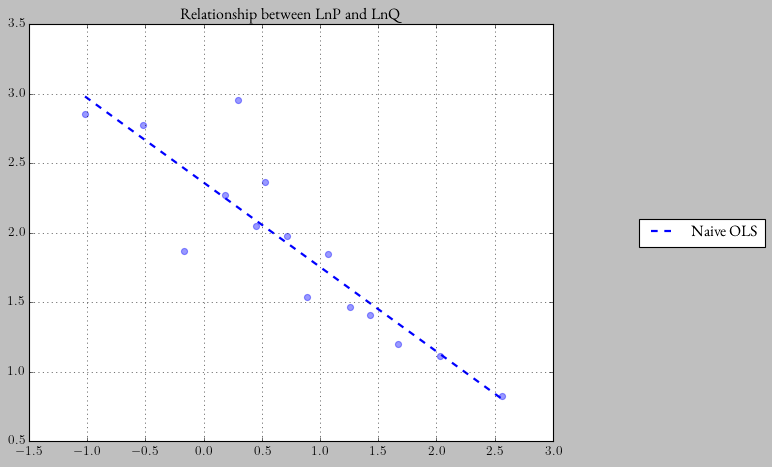

In [5]:
# === 绘制 Naive OLS 结果 ======
plt.figure(figsize=(10, 6))  # 创建画布

ols_fit = binned_ols(
    df_mdl,
    x="LnP",
    y="LnQ",
    n_bins=15,
    plot_ax=plt.gca(),  # 使用当前轴
    plot_title="Relationship between LnP and LnQ",
    label="Naive OLS"  # <--- 【关键】必须加这一行
)

# 设置图例在外部
plt.legend(loc="center left", bbox_to_anchor=(1.15, 0.5))


# 保存
plt.grid()
plt.tight_layout()
plt.savefig("observe_messy_relationship_LnP_LnQ.pdf")
plt.show()


In [6]:
print(ols_fit.summary())


                            OLS Regression Results                            
Dep. Variable:                    LnQ   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     50.05
Date:                Sat, 27 Dec 2025   Prob (F-statistic):           8.36e-06
Time:                        10:29:01   Log-Likelihood:                -2.5618
No. Observations:                  15   AIC:                             9.124
Df Residuals:                      13   BIC:                             10.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3628      0.103     22.981      0.0

/Users/haoyi/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  res = hypotest_fun_out(*samples, **kwds)


In [7]:
# ===== 计算 MSE 与 RMSE ======
mse_val = ols_fit.mse_resid

rmse_val = np.sqrt(mse_val)

print(f"Binned MSE: {mse_val}")
print(f"Binned RMSE: {rmse_val}")


Binned MSE: 0.09506481334335092
Binned RMSE: 0.3083258233482089


#### subsection 2.2 Possion and Ridge

最终柏松回归中LnP的回归系数为 -2.87559，Ridge—OLS回归中LnP的回归系数为 -1.79945，尝试下来各个方法得到的结果差异很大。

In [8]:
# ===== Package: ML =====
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error


In [9]:
# ===== 生成基本的控制变量(特征) =====
feature_generator_basic = ColumnTransformer(
    [
        ("StockCode", OneHotEncoder(), ["StockCode"]),
        ("Date", OneHotEncoder(), ["Date"]),
        ("Country", OneHotEncoder(), ["Country"]),
        ("LnP", "passthrough", ["LnP"]),
    ],
    remainder="drop",
)


In [10]:
# ===== 构造 Poisson Regression(基本的控制变量) =====
mdl_poisson = Pipeline(
    [
        ("feat_proc", feature_generator_basic),
        (
            "reg",
            linear_model.PoissonRegressor(
                alpha=1e-6,  # l2 penalty strength; manually selected value for minimum interference on LnP-coef (elasticity)
                fit_intercept=False,  # no need, since we have OneHot encodings without drop
                max_iter=100_000,
            ),
        ),
    ],
    verbose=True,
)


In [11]:
# ===== 构造 Ridge Regression(基本的控制变量) =====
mdl_ridge = Pipeline(
    [
        ("feat_proc", feature_generator_basic),
        (
            "reg",
            linear_model.Ridge(
                alpha=1e-20,  # l2 penalty strength
                fit_intercept=False,
                max_iter=100_000,
            ),
        ),
    ],
    verbose=True,
)


In [12]:
# ===== Poisson with 基本控制变量的训练 =====
mdl_poisson.fit(
    df_mdl[['LnP', 'StockCode', 'Date', 'Country']], 
    df_mdl['Quantity'] # Poisson regression has log-link, so LnQ is implicit in loss function
)


[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   0.2s


/Users/haoyi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/haoyi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/haoyi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)


[Pipeline] ............... (step 2 of 2) Processing reg, total=  15.7s


Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('StockCode', OneHotEncoder(),
                                                  ['StockCode']),
                                                 ('Date', OneHotEncoder(),
                                                  ['Date']),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('LnP', 'passthrough',
                                                  ['LnP'])])),
                ('reg',
                 PoissonRegressor(alpha=1e-06, fit_intercept=False,
                                  max_iter=100000))],
         verbose=True)

In [13]:
# ===== Ridge with 基本控制变量的训练 =====
mdl_ridge.fit(
    df_mdl[['LnP', 'StockCode', 'Date', 'Country']], 
    df_mdl['LnQ'] # log-normal
)


[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   0.2s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   0.3s


Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('StockCode', OneHotEncoder(),
                                                  ['StockCode']),
                                                 ('Date', OneHotEncoder(),
                                                  ['Date']),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('LnP', 'passthrough',
                                                  ['LnP'])])),
                ('reg',
                 Ridge(alpha=1e-20, fit_intercept=False, max_iter=100000))],
         verbose=True)

In [14]:
# ===== Poisson 回归的结果参数 =====
print('"Econometrically" estimated elasticity with unit-, time-, and market- controls, using Poisson loss (coef on LnP):')

pd.DataFrame({
    'feat': mdl_poisson['feat_proc'].get_feature_names_out(),
    'coef': mdl_poisson['reg'].coef_
}).iloc[-1]



"Econometrically" estimated elasticity with unit-, time-, and market- controls, using Poisson loss (coef on LnP):


feat    LnP__LnP
coef   -2.977103
Name: 3709, dtype: object

In [15]:
# ===== Ridge 回归的结果参数 =====
print('"Econometrically" estimated elasticity with unit-, time-, and market- controls, using log-Normal loss (coef on LnP):')
pd.DataFrame({
    'feat': mdl_ridge['feat_proc'].get_feature_names_out(),
    'coef': mdl_ridge['reg'].coef_
}).iloc[-1]


"Econometrically" estimated elasticity with unit-, time-, and market- controls, using log-Normal loss (coef on LnP):


feat    LnP__LnP
coef   -1.927316
Name: 3709, dtype: object

In [16]:
# ===== 计算 MSE 与 RMSE =====

# ==========================================
# 1. 准备数据与真实值 (Ground Truth)
# ==========================================
# 特征矩阵 (两个模型用的是一样的特征)
X = df_mdl[["LnP", "StockCode", "Date", "Country"]]

# 真实值 (必须统一还原到 "原始销量" 才能进行公平对比)
# 假设 df_mdl['LnQ'] 是 log(Quantity)
y_true_original = np.exp(df_mdl["LnQ"])


# ==========================================
# 2. 计算 OLS 模型的 MSE
# ==========================================
# OLS 训练目标是 LnQ，所以预测输出也是 log 尺度
pred_log_ols = mdl_ridge.predict(X)

# 【关键步骤】必须手动指数还原
pred_ols_original = np.exp(pred_log_ols)

# 计算 OLS 在原始尺度下的 MSE
mse_ols = mean_squared_error(y_true_original, pred_ols_original)


# ==========================================
# 3. 计算 Poisson 模型的 MSE
# ==========================================
# Poisson 训练时，y 通常直接输入原始 Quantity (或者 sklearn 内部处理 link function)
# 【关键区别】predict() 方法默认返回 E[y]，也就是预测的“销量数值”
# 不需要手动 np.exp()，sklearn 已经帮你做了 inverse link function
pred_poisson_original = mdl_poisson.predict(X)

# 直接计算 Poisson 在原始尺度下的 MSE
mse_poisson = mean_squared_error(y_true_original, pred_poisson_original)


# ==========================================
# 4. 汇报与打印
# ==========================================
print("----- Model Comparison (Original Scale) -----")
print(f"1. OLS MSE     : {mse_ols:.4f}")
print(f"2. Poisson MSE : {mse_poisson:.4f}")
print("-" * 30)
print(f"1. OLS RMSE     : {np.sqrt(mse_ols):.4f} (件)")
print(f"2. Poisson RMSE : {np.sqrt(mse_poisson):.4f} (件)")

# 简单的判断逻辑
if mse_poisson < mse_ols:
    print("\n[结论]: Poisson 模型在预测实际销量上更准确。")
else:
    print("\n[结论]: OLS 模型表现更好（可能数据分布并不完全符合泊松假设）。")


----- Model Comparison (Original Scale) -----
1. OLS MSE     : 21342.0177
2. Poisson MSE : 17406.1048
------------------------------
1. OLS RMSE     : 146.0891 (件)
2. Poisson RMSE : 131.9322 (件)

[结论]: Poisson 模型在预测实际销量上更准确。


In [17]:
# ===== 考虑更多的混杂因素 =====

feature_generator_full = ColumnTransformer(
    [
        (
            "StockCode",
            OneHotEncoder(handle_unknown="ignore"),
            ["StockCode"],
        ),
        (
            "Date",
            OneHotEncoder(),
            ["month","DoM","DoW",],
        ),
        (
            "Description",
            CountVectorizer(min_df=0.0025, ngram_range=(1, 3)),
            "Description",
        ),
        ("Country", OneHotEncoder(), ["Country"]),
        (
            "numeric_feats",
            StandardScaler(),
            ["stock_age_days", "sku_avg_p"],
        ),
        ("LnP", "passthrough", ["LnP"]),
    ],
    remainder="drop",
)


In [18]:
# ===== 构造 Poisson Regression(更多的控制变量) =====

mdl_poisson_full = Pipeline(
    [
        ("feat_proc", feature_generator_full),
        (
            "reg",
            linear_model.PoissonRegressor(
                alpha=1e-6,  # l2 penalty strength; manually selected value for minimum interference on LnP-coef (elasticity)
                fit_intercept=False,  # no need, since we have OneHot encodings without drop
                max_iter=100_000,
            ),
        ),
    ],
    verbose=True,
)


In [19]:
# ===== 构造 Ridge Regression(更多的控制变量) =====
mdl_ridge_full = Pipeline(
    [
        ("feat_proc", feature_generator_full),
        (
            "reg",
            linear_model.Ridge(
                alpha=1e-20,  # l2 penalty strength
                fit_intercept=False,
                max_iter=100_000,
            ),
        ),
    ],
    verbose=True,
)


In [20]:
# 定义需要的特征列列表
feature_cols = [
    "LnP",  # Treatment
    "StockCode",
    "Country",  # Confounder (Region FE)
    "Description",  # Confounder (Text Features)
    "month",
    "DoM",
    "DoW",
    "stock_age_days",
    "sku_avg_p",  # Confounders (Numeric)
]


In [21]:
# ===== Poisson with 更多控制变量的训练 =====
mdl_poisson_full.fit(df_mdl[feature_cols], df_mdl["Quantity"])


[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   2.4s


/Users/haoyi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/haoyi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/Users/haoyi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)


[Pipeline] ............... (step 2 of 2) Processing reg, total=  42.5s


Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('StockCode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['StockCode']),
                                                 ('Date', OneHotEncoder(),
                                                  ['month', 'DoM', 'DoW']),
                                                 ('Description',
                                                  CountVectorizer(min_df=0.0025,
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'Description'),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('numeric_feats',
                                                  StandardScaler(),
                                                  ['stock_age_days',
                                                   'sku_avg_p']),
                                                 ('LnP', 'passthrough',
                                                  ['LnP'])])),
                ('reg',
                 PoissonRegressor(alpha=1e-06, fit_intercept=False,
                                  max_iter=100000))],
         verbose=True)

In [22]:
# ===== Poisson 回归的结果参数 =====
print(
    '"Econometrically" estimated elasticity with unit-, time-, and market- controls, using Poisson loss (coef on LnP):'
)

pd.DataFrame(
    {
        "feat": mdl_poisson_full["feat_proc"].get_feature_names_out(),
        "coef": mdl_poisson_full[-1].coef_
    }
).iloc[-1]


"Econometrically" estimated elasticity with unit-, time-, and market- controls, using Poisson loss (coef on LnP):


feat    LnP__LnP
coef   -2.961991
Name: 4007, dtype: object

In [23]:
# ===== Ridge with 基本控制变量的训练 =====
mdl_ridge_full.fit(df_mdl[feature_cols], df_mdl["LnQ"])


[Pipeline] ......... (step 1 of 2) Processing feat_proc, total=   2.5s
[Pipeline] ............... (step 2 of 2) Processing reg, total=   2.7s


Pipeline(steps=[('feat_proc',
                 ColumnTransformer(transformers=[('StockCode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['StockCode']),
                                                 ('Date', OneHotEncoder(),
                                                  ['month', 'DoM', 'DoW']),
                                                 ('Description',
                                                  CountVectorizer(min_df=0.0025,
                                                                  ngram_range=(1,
                                                                               3)),
                                                  'Description'),
                                                 ('Country', OneHotEncoder(),
                                                  ['Country']),
                                                 ('numeric_feats',
                                                  StandardScaler(),
                                                  ['stock_age_days',
                                                   'sku_avg_p']),
                                                 ('LnP', 'passthrough',
                                                  ['LnP'])])),
                ('reg',
                 Ridge(alpha=1e-20, fit_intercept=False, max_iter=100000))],
         verbose=True)

In [24]:
# ===== Ridge 回归的结果参数 =====
print(
    '"Econometrically" estimated elasticity with unit-, time-, and market- controls, using log-Normal loss (coef on LnP):'
)
pd.DataFrame(
    {
        "feat": mdl_ridge["feat_proc"].get_feature_names_out(),
        "coef": mdl_ridge["reg"].coef_,
    }
).iloc[-1]


"Econometrically" estimated elasticity with unit-, time-, and market- controls, using log-Normal loss (coef on LnP):


feat    LnP__LnP
coef   -1.927316
Name: 3709, dtype: object

In [25]:
# ===== 计算 MSE 与 RMSE =====

# ==========================================
# 1. 准备数据与真实值 (Ground Truth)
# ==========================================
# 特征矩阵 
X = df_mdl[feature_cols]

# 真实值
y_true_original = np.exp(df_mdl["LnQ"])


# ==========================================
# 2. 计算 OLS 模型的 MSE
# ==========================================
# OLS 训练目标是 LnQ，所以预测输出也是 log 尺度
pred_log_ols = mdl_ridge_full.predict(X)

pred_ols_original = np.exp(pred_log_ols)

# 计算 OLS 在原始尺度下的 MSE
mse_ols = mean_squared_error(y_true_original, pred_ols_original)


# ==========================================
# 3. 计算 Poisson 模型的 MSE
# ==========================================

pred_poisson_original = mdl_poisson_full.predict(X)

# 直接计算 Poisson 在原始尺度下的 MSE
mse_poisson = mean_squared_error(y_true_original, pred_poisson_original)


# ==========================================
# 4. 汇报与打印
# ==========================================
print("----- Model Comparison (Original Scale) -----")
print(f"1. OLS MSE     : {mse_ols:.4f}")
print(f"2. Poisson MSE : {mse_poisson:.4f}")
print("-" * 30)
print(f"1. OLS RMSE     : {np.sqrt(mse_ols):.4f} (件)")
print(f"2. Poisson RMSE : {np.sqrt(mse_poisson):.4f} (件)")

# 简单的判断逻辑
if mse_poisson < mse_ols:
    print("\n[结论]: Poisson 模型在预测实际销量上更准确。")
else:
    print("\n[结论]: Ridge 模型表现更好（可能数据分布并不完全符合泊松假设）。")


----- Model Comparison (Original Scale) -----
1. OLS MSE     : 21359.9159
2. Poisson MSE : 20112.7043
------------------------------
1. OLS RMSE     : 146.1503 (件)
2. Poisson RMSE : 141.8193 (件)

[结论]: Poisson 模型在预测实际销量上更准确。


In [26]:
from sklearn.ensemble import RandomForestRegressor

feats_rf = ColumnTransformer(
    [
        (
            "StockCode",
            OneHotEncoder(handle_unknown="ignore"),
            ["StockCode"],
        ),
        (
            "Date",
            OneHotEncoder(),
            [
                "month",
                "DoM",
                "DoW",
            ],
        ),
        (
            "Description",
            CountVectorizer(min_df=0.0025, ngram_range=(1, 3)),
            "Description",
        ),
        ("Country", OneHotEncoder(), ["Country"]),
        (
            "numeric_feats",
            StandardScaler(),
            ["stock_age_days", "sku_avg_p"],
        ),
    ],
    remainder="drop",
)


In [27]:
feature_cols = [
    "StockCode",
    "Country",  # Confounder (Region FE)
    "Description",  # Confounder (Text Features)
    "month",
    "DoM",
    "DoW",
    "stock_age_days",
    "sku_avg_p",  # Confounders (Numeric)
]


In [28]:
model_q = Pipeline([
    ('feat_proc', feats_rf),
    ('model_q', RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1, verbose=2)) 

])
model_p = Pipeline([
    ('feat_proc', feature_generator_full),
    ('model_p', RandomForestRegressor(n_estimators=50, min_samples_leaf=3, n_jobs=-1, verbose=2))
])


In [29]:
# 1. 训练 Y 模型（用混淆因子预测销量）

# model_q.fit(df_mdl[feature_cols], df_mdl["LnQ"])
# joblib.dump(model_q, "DML_model_q.pkl")


In [30]:

# 2. 训练 P 模型（用混淆因子预测价格）

# model_p.fit(df_mdl, df_mdl["LnP"])
# joblib.dump(model_p, "DML_model_p.pkl")


In [31]:

model_q = joblib.load("DML_model_q.pkl")
model_p = joblib.load("DML_model_p.pkl")

# 3. 现在模型已经训练好了，可以进行预测 (计算残差的基础)
q_hat = model_q.predict(df_mdl)  # 预测出的销量基准
p_hat = model_p.predict(df_mdl)  # 预测出的价格基准


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.5s finished


In [32]:
# 计算正交残差
df_mdl = df_mdl.assign(
    dLnP_res = df_mdl['dLnP'] - p_hat,
    dLnQ_res = df_mdl['dLnQ'] - q_hat,
)


In [33]:
# 3-Stage

df_mdl[["LnP","LnQ", "dLnP","dLnQ", "dLnP_res",	"dLnQ_res"]].sample(5)


,LnP,LnQ,dLnP,dLnQ,dLnP_res,dLnQ_res
127046,1.832581,0.693147,-0.051369,-1.015840,-1.941156,-2.531960
142815,1.321756,0.000000,-0.073761,-2.666045,-1.448772,-3.711006
35911,0.223144,0.000000,-0.259243,-2.251292,-0.480903,-3.380198
143705,0.805445,4.174387,-0.068101,0.484482,-0.920878,-2.784428
17941,0.936093,3.178054,-0.055727,0.577722,-0.991821,-2.307814


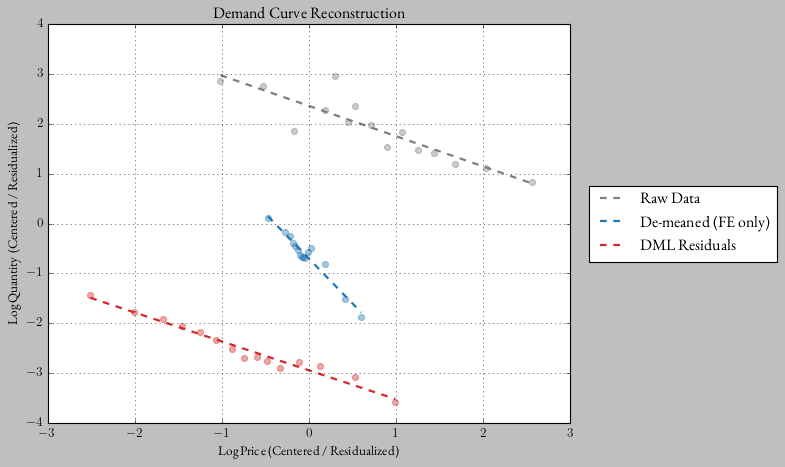

In [34]:
# 设置画布大小
plt.figure(figsize=(10, 6))

# --- Stage 1: 原始数据 (Raw) ---

fit_raw = binned_ols(
    df_mdl,
    x="LnP",
    y="LnQ",
    n_bins=15,
    plot_ax=plt.gca(),
    color="tab:gray",  # 颜色
    label="Raw Data",  # 图例
    plot_title="Demand Curve Reconstruction"
)

# --- Stage 2: 去均值化 (De-meaned) ---
fit_demean = binned_ols(
    df_mdl,
    x="dLnP",
    y="dLnQ",
    n_bins=15,
    plot_ax=plt.gca(),
    color="tab:blue",
    label="De-meaned (FE only)",
)

# --- Stage 3: DML 残差 (DML Residuals) ---
fit_dml = binned_ols(
    df_mdl,
    x="dLnP_res",
    y="dLnQ_res",
    n_bins=15,
    plot_ax=plt.gca(),
    color="tab:red",
    label="DML Residuals",
)


plt.gca().set(
    xlabel="Log Price (Centered / Residualized)",
    ylabel="Log Quantity (Centered / Residualized)",
)


plt.legend(
    loc="center left", bbox_to_anchor=(1.02, 0.5)
)
plt.grid()
plt.tight_layout()
plt.savefig("demand_curve_comparison.pdf")

plt.show()


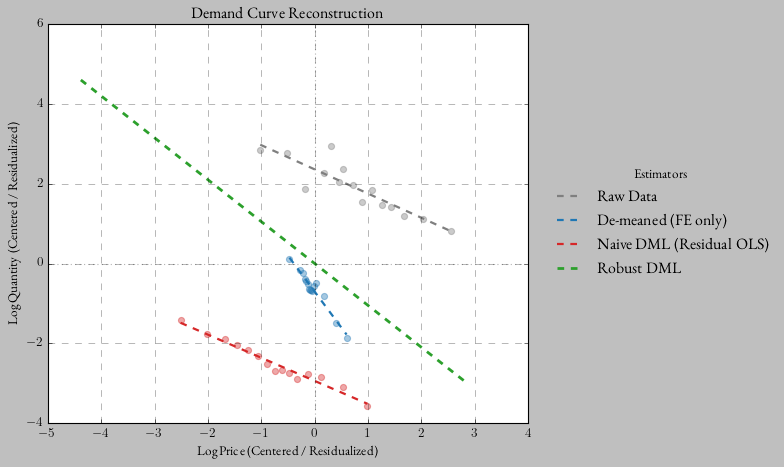

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# 设置画布
plt.figure(figsize=(10, 6))

# ==========================================
# 1. 绘制前三个阶段 (调用 binned_ols)
# ==========================================

# --- Stage 1: 原始数据 (Raw) ---
fit_raw = binned_ols(
    df_mdl,
    x="LnP",
    y="LnQ",
    n_bins=15,
    plot_ax=plt.gca(),
    color="tab:gray",
    label="Raw Data",
    plot_title="Demand Curve Reconstruction",
)

# --- Stage 2: 去均值化 (De-meaned) ---
fit_demean = binned_ols(
    df_mdl,
    x="dLnP",
    y="dLnQ",
    n_bins=15,
    plot_ax=plt.gca(),
    color="tab:blue",
    label="De-meaned (FE only)",
)

# --- Stage 3: DML 残差 (Naive DML) ---
# 注意：这里 binned_ols 画出的拟合线本质上是 Naive DML (直接对残差回归)
fit_dml = binned_ols(
    df_mdl,
    x="dLnP_res",
    y="dLnQ_res",
    n_bins=15,
    plot_ax=plt.gca(),
    color="tab:red",
    label="Naive DML (Residual OLS)",
)

# ==========================================
# 2. 绘制第四阶段: Robust DML
# ==========================================

# 第一步：手动计算 Robust DML 的斜率 (Theta)
# 公式: Cov(P_res, Q_res) / Cov(P_res, P_raw)
num = np.dot(df_mdl["dLnP_res"], df_mdl["dLnQ_res"])
den = np.dot(df_mdl["dLnP_res"], df_mdl["LnP"])
theta_robust = num / den

# 获取当前 X 轴的范围 (基于 Stage 3 的残差分布)
x_min, x_max = df_mdl["dLnP_res"].min()+1, df_mdl["dLnP_res"].max()
x_line = np.linspace(x_min, x_max, 50)
# y = kx (残差回归没有截距，过原点)
y_line = theta_robust * x_line

# 第三步：绘制 Robust 线
# 使用鲜艳的绿色，实线，加粗，以示区别
plt.plot(
    x_line,
    y_line,
    color="tab:green",
    linestyle="--",
    linewidth=2.5,
    label= "Robust DML",
)

# ==========================================
# 3. 装饰与保存
# ==========================================

plt.gca().set(
    xlabel="Log Price (Centered / Residualized)",
    ylabel="Log Quantity (Centered / Residualized)",
)

# 添加参考线
plt.axvline(0, color="k", linestyle=":", alpha=0.3)
plt.axhline(0, color="k", linestyle=":", alpha=0.3)

# 图例设置
plt.legend(
    loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False, title="Estimators"
)

plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("demand_curve_comparison_robust.pdf", bbox_inches="tight")

plt.show()


In [36]:
import numpy as np
from sklearn.metrics import mean_squared_error


# --- 之前的代码保持不变 ---
def report_metrics(stage_name, res, slope_var_name):
    mse = res.mse_resid
    rmse = np.sqrt(mse)
    try:
        elasticity = res.params[slope_var_name]
    except KeyError:
        # 如果找不到变量名，尝试取最后一个参数（通常是斜率，因为常数项在前）
        elasticity = res.params.iloc[-1]

    print(f"[{stage_name}]")
    print(f"  Elasticity (Slope): {elasticity:.4f}")
    print(f"  Binned MSE        : {mse:.4f}")
    print(f"  Binned RMSE       : {rmse:.4f}")
    print("-" * 30)


print("\n=== Model Diagnostics (Binned Fit) ===")
report_metrics("Stage 1: Raw", fit_raw, "LnP")
report_metrics("Stage 2: De-meaned", fit_demean, "dLnP")
report_metrics("Stage 3: Naive DML", fit_dml, "dLnP_res")  # 建议改名为 Naive DML 以区分

# =======================================================
# 【新增】Stage 4: Robust DML 的指标计算
# =======================================================

# 1. 计算 Robust DML 弹性系数 (Theta)
# 公式: Cov(P_res, Q_res) / Cov(P_res, P_raw)
num = np.dot(df_mdl["dLnP_res"], df_mdl["dLnQ_res"])
den = np.dot(df_mdl["dLnP_res"], df_mdl["LnP"])
theta_robust = num / den

# 2. 获取分箱后的数据 (复用 fit_dml 中的数据)
# fit_dml 是 Stage 3 的回归结果，它内部存储了分箱后的均值点
# model.endog 是 Y (LnQ_res 均值)
# model.exog 是 X (包含常数项和 LnP_res 均值)
y_binned_true = fit_dml.model.endog
x_binned = fit_dml.model.exog[:, 1]  # 取第2列，即 x 变量，避开常数项

# 3. 计算预测值
# 理论上残差回归过原点 (Intercept=0)，预测值 = x * theta
y_binned_pred = x_binned * theta_robust

# 4. 计算 MSE 和 RMSE
mse_robust = mean_squared_error(y_binned_true, y_binned_pred)
rmse_robust = np.sqrt(mse_robust)

print("[Stage 4: Robust DML]")
print(f"  Elasticity (Slope): {theta_robust:.4f}")
print(f"  Binned MSE        : {mse_robust:.4f}")
print(f"  Binned RMSE       : {rmse_robust:.4f}")
print("-" * 30)



=== Model Diagnostics (Binned Fit) ===
[Stage 1: Raw]
  Elasticity (Slope): -0.6074
  Binned MSE        : 0.0951
  Binned RMSE       : 0.3083
------------------------------
[Stage 2: De-meaned]
  Elasticity (Slope): -1.8025
  Binned MSE        : 0.0142
  Binned RMSE       : 0.1193
------------------------------
[Stage 3: Naive DML]
  Elasticity (Slope): -0.5803
  Binned MSE        : 0.0117
  Binned RMSE       : 0.1083
------------------------------
[Stage 4: Robust DML]
  Elasticity (Slope): -1.0511
  Binned MSE        : 11.1368
  Binned RMSE       : 3.3372
------------------------------


In [37]:
def get_feat_generator_names(gen):
    res = []
    for i, (k, t) in enumerate(gen.named_transformers_.items()):
        if k == 'remainder':
            continue
        
        res += [f'{k}_{n}' for n in t.get_feature_names()]

    return res


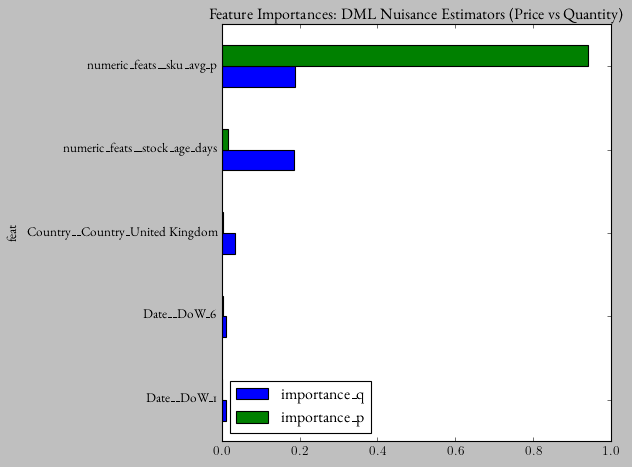

In [38]:
# Plot: 绘制价格模型的重要特征
feat_names = model_p.named_steps["feat_proc"].get_feature_names_out()

feat_imp = pd.DataFrame(
    {
        "feat": feat_names,
        "importance_q": model_q.named_steps["model_q"].feature_importances_,
        "importance_p": model_p.named_steps["model_p"].feature_importances_,
    }
).set_index("feat")

feat_imp.sort_values(by="importance_p").iloc[-5:].plot.barh(
    title="Feature Importances: DML Nuisance Estimators (Price vs Quantity)",
)
plt.tight_layout()
plt.show()
